In [ ]:
# SIR Simulation

import numpy as np
import scipy as sp
import networkx as nx

def SIR(G: nx.Graph, rho: float, beta: float, simulation_time: int, x0: np.ndarray, vaccines = None):
    '''
    Simulate the SIR discrete dynamics over a network. The following parameters are accpted:
    - G is the graph describing the network
    - rho is the probability of an infected node to recover spontaneously
    - beta is the probability of spreading the infection
    - simulation_time is self-explanatory
    - x0 is the initial condition
    - vaccine is the array containing the cumulative percentage of vaccined people over the weeks.
      Vaccinated people are counted torward the recovered
    As convention is used that:
    - 0 means the node is susceptible
    - 1 means the node is infected
    - 2 means the node is recovered
    - 3 mean the node is vaccinated (if vaccines are used)
    '''

    infected = np.zeros(simulation_time, dtype=int)
    sucsceptibles = np.zeros(simulation_time, dtype=int)
    recovered = np.zeros(simulation_time, dtype=int)
    newly_infected = np.zeros(simulation_time, dtype=int)

    W = nx.to_numpy_array(G)
    n_agents = len(G)
    x = np.array(x0)

    #Retrieve the weekly distribution of vaccines
    if vaccines is not None:
        vaccines = np.diff(vaccines, n=1)
        vaccines/=100
        vaccinated = np.zeros(simulation_time, dtype=int)

    for t in range(0,simulation_time):
        #SIR counter
        counter = np.zeros(4)
        #New state
        y = np.array(x)
        #Distribute vaccines
        if vaccines is not None:
            unvaccinated = [i for i in range(n_agents) if x[i]!=3]
            n_vaccines = int(vaccines[t]*n_agents)
            vaccinated_agents = np.random.choice(unvaccinated,size=n_vaccines, replace=False)
            x[vaccinated_agents] = 3
        #Compute what the new state will be for each agent
        for agent in range(n_agents):
            #Case where the node is susceptible
            if x[agent] == 0:
                #Number of infected neighbours
                m = W[agent,:]*(x==1)
                m = m.sum()
                #Probability of remaining susceptible
                prob = (1-beta)**m
                new_state = np.random.choice([0, 1], p=[prob, 1-prob])
                counter[new_state]+=1
                y[agent] = new_state
                if new_state == 1:
                    newly_infected[t]+=1
            #Case where the node is infected
            elif x[agent] == 1:
                new_state = np.random.choice([1, 2], p=[1-rho, rho])
                counter[new_state]+=1
                y[agent] = new_state
            #Case where the node is recovered or vaccinated
            else:
                counter[x[agent]]+=1
                y[agent] = x[agent]
        sucsceptibles[t] = counter[0]
        infected[t] = counter[1]
        recovered[t] = counter[2]
        if vaccines is not None:
            vaccinated[t] = counter[3]
        x = y

    if vaccines is not None:
        return sucsceptibles, infected, recovered, newly_infected, vaccinated
    else:
        return sucsceptibles, infected, recovered, newly_infected

In [ ]:
# Generate Random Graph

import numpy as np
import networkx as nx

def createRadnomGraph(k: int, target_size: int) -> nx.Graph:
    '''
    Create a random graph with average degree close to k with target_size number of nodes
    '''
    #Start by creating a complete graph with k+1 nodes
    G = nx.complete_graph(k+1)
    #Nodes counter
    j = k+2

    while j<=target_size:
        W = nx.to_numpy_array(G)
        nodes = list(G.nodes())
        w = np.sum(W,axis=1)
        #Probability of attaching new node to each already existing node
        prob = w/np.sum(w)
        #This trick is used to deal with k being odd
        c = np.floor(k/2) if j%2==0 else np.ceil(k/2)
        #Choose the nodes to which attach the new node
        chosen_nodes = np.random.choice(nodes,p=prob,size=int(c), replace=False)
        for n in chosen_nodes:
            G.add_edge(n,j)
        j+=1

    return G



In [ ]:
# Search for parameters

import numpy as np
import networkx as nx
from itertools import product
from math import inf

def parameterSearch(n_nodes: int, simulation_time: int, N:int, vaccines: np.ndarray, true_infected: np.ndarray, initial_random_guess):
    '''
    Search the set of parameters k, beta and rho that best compare to the ground truth (true_infected)
    when simulating an epidemic model with vaccines, where the network is composed of n_nodes nodes.
    The simulation is carried for simulation_time iterations and each simulation is repeated N times.
    A dictionary structured as [k, beta, tho]: [rmse, susceptibles, infercted recovered, new_infected, vaccinated] is returned
    '''

    #Initial random guess
    k = initial_random_guess[0]
    beta = initial_random_guess[1]
    rho = initial_random_guess[2]
    dk = 1
    dbeta = 0.1
    drho = 0.1
    #Parameters set
    k_set = [k-dk, k, k+dk]
    beta_set = [beta-dbeta if beta-dbeta>=0 else 0, beta, beta+dbeta if beta+dbeta<=1 else 1]
    rho_set = [rho-drho if rho-drho>=0 else 0, rho, rho+drho if rho+drho<=1 else 1]

    #Combinations of all possible parameters
    parameters_combs = list(product(k_set,beta_set,rho_set))

    #Assign to each combination an rmse
    parameters_rmse = {c:[inf, np.zeros(simulation_time), np.zeros(simulation_time), np.zeros(simulation_time), np.zeros(simulation_time), np.zeros(simulation_time) ] for c in parameters_combs}

    for c in parameters_combs:
        #Retrieve parameters
        k = c[0]
        beta = c[1]
        rho = c[2]

        #Generate graph
        G = createRadnomGraph(k,n_nodes)

        #Initial condition
        x0 = np.zeros(n_nodes, dtype = int)
        n_infected= 1
        infected = np.random.choice(range(0,n_nodes),size=n_infected,replace=False)
        vaccinated = np.random.choice([i for i in range(n_nodes) if x0[i]==0],int(vaccines[0]/100*n_nodes),replace=False)
        x0[infected] = 1
        x0[vaccinated] = 3

        #Simulate epidemic
        total_susc = np.zeros(simulation_time)
        total_inf = np.zeros(simulation_time)
        total_rec = np.zeros(simulation_time)
        total_vacc = np.zeros(simulation_time)
        new_inf = np.zeros(simulation_time)
        for _ in range(N):
            susceptibles, infected, recovered, newly_infected, vaccinated = SIR(G,rho,beta,simulation_time,x0,vaccines=vaccines)
            total_susc+=susceptibles
            total_inf+=infected
            total_rec+=recovered
            new_inf+=newly_infected
            total_vacc+=vaccinated

        total_susc/=N
        total_inf/=N
        total_rec/=N
        new_inf/=N
        total_vacc/=N

        rmse = np.sqrt(1/simulation_time*np.sum(np.square(new_inf-true_infected)))
        parameters_rmse[c] = [rmse, total_susc, total_inf, total_rec, new_inf, total_vacc]
        if rmse == 0.0:
            break

    return parameters_rmse



Total susceptibles distribution over the 15 weeks:
[478.3  466.84 458.18 451.76 447.3  444.19 441.93 440.5  439.31 438.58
 437.86 437.5  437.17 437.01 436.86]

Total infected distribution over the 15 weeks:
[14.93 16.11 13.29 10.45  7.53  5.5   3.92  2.68  2.14  1.35  1.1   0.7
  0.57  0.31  0.29]

Total recovered distribution over the 15 weeks:
[ 6.77 17.05 28.53 37.79 45.17 50.31 54.15 56.82 58.55 60.07 61.04 61.8
 62.26 62.68 62.85]

New infected distribution over the 15 weeks:
[11.7  11.46  8.66  6.42  4.46  3.11  2.26  1.43  1.19  0.73  0.72  0.36
  0.33  0.16  0.15]



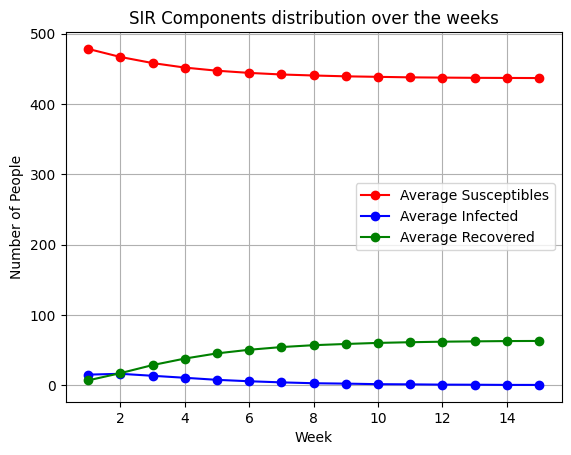

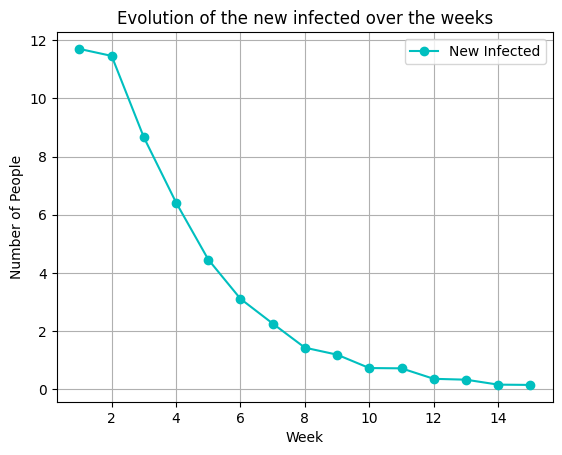

In [ ]:
# Ex 1.1.1

import matplotlib.pyplot as plt

G = nx.Graph()
n_nodes = 500
k = 4 # link of each node
for i in range(n_nodes):
    for j in range(1,int(k/2)+1):
        G.add_edge(i,(i+j)%n_nodes)

x0 = np.zeros(n_nodes, dtype = int)
n_infected= 10
infected = np.random.choice(range(0,n_nodes),n_infected,replace=False)
x0[infected] = 1

N = 100
n_weeks = 15
total_susc = np.zeros(n_weeks)
total_inf = np.zeros(n_weeks)
total_rec = np.zeros(n_weeks)
new_inf = np.zeros(n_weeks)
for _ in range(N):
    susceptibles, infected, recovered, newly_infected = SIR(G,0.7,0.3,n_weeks,x0)
    total_susc+=susceptibles
    total_inf+=infected
    total_rec+=recovered
    new_inf+=newly_infected

total_susc/=N
total_inf/=N
total_rec/=N
new_inf/=N

print(f'Total susceptibles distribution over the {n_weeks} weeks:\n{total_susc}\n')
print(f'Total infected distribution over the {n_weeks} weeks:\n{total_inf}\n')
print(f'Total recovered distribution over the {n_weeks} weeks:\n{total_rec}\n')
print(f'New infected distribution over the {n_weeks} weeks:\n{new_inf}\n')

plt.plot(range(1,n_weeks+1),total_susc,'ro-',label='Average Susceptibles')
plt.plot(range(1,n_weeks+1),total_inf,'bo-',label='Average Infected')
plt.plot(range(1,n_weeks+1),total_rec,'go-',label='Average Recovered')
plt.title('SIR Components distribution over the weeks')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1,n_weeks+1),new_inf,'co-')
plt.legend(['New Infected'])
plt.title('Evolution of the new infected over the weeks')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.grid()
plt.show()


In [ ]:
# Ex 1.1.2

k = 11
target_size = 1000
G = createRadnomGraph(k,target_size)
W = nx.to_numpy_array(G)
w = np.sum(W,axis=1)
print(f'Aevrage graph degree is {np.mean(w)} (target value is k={k})')


Aevrage graph degree is 11.0 (target value is k=11)


Total susceptibles distribution over the 15 weeks:
[471.72 419.22 307.95 199.75 139.32 111.27  99.48  94.8   92.78  91.93
  91.59  91.46  91.38  91.38  91.38]

Total infected distribution over the 15 weeks:
[2.1210e+01 5.8890e+01 1.2947e+02 1.4702e+02 1.0392e+02 5.9520e+01
 2.9840e+01 1.3890e+01 6.0100e+00 2.6000e+00 1.0900e+00 4.1000e-01
 2.0000e-01 6.0000e-02 1.0000e-02]

Total recovered distribution over the 15 weeks:
[  7.07  21.89  62.58 153.23 256.76 329.21 370.68 391.31 401.21 405.47
 407.32 408.13 408.42 408.56 408.61]

New infected distribution over the 15 weeks:
[1.8280e+01 5.2500e+01 1.1127e+02 1.0820e+02 6.0430e+01 2.8050e+01
 1.1790e+01 4.6800e+00 2.0200e+00 8.5000e-01 3.4000e-01 1.3000e-01
 8.0000e-02 0.0000e+00 0.0000e+00]



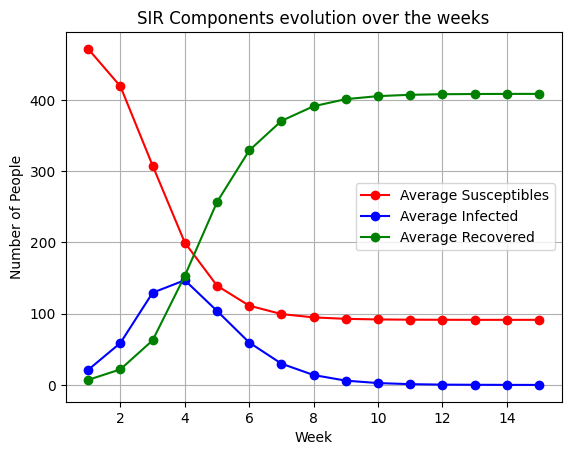

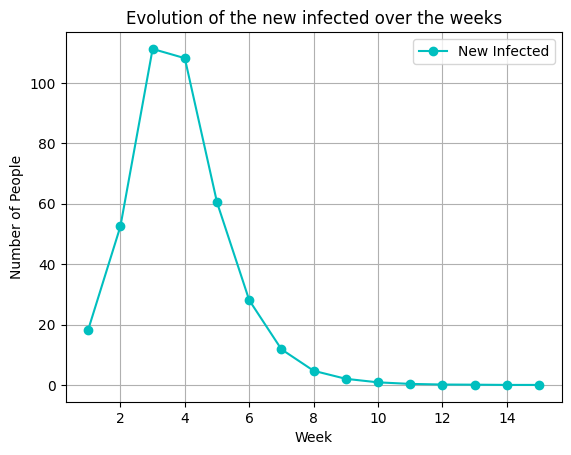

In [ ]:
# Ex 1.2

#Model parameters
n_nodes = 500
k = 6
beta = 0.3
rho = 0.7
N = 100

#Initialization
x0 = np.zeros(n_nodes, dtype = int)
n_infected= 10
infected = np.random.choice(range(0,n_nodes),n_infected,replace=False)
x0[infected] = 1
G = createRadnomGraph(k,n_nodes)

#Simulation
n_weeks = 15
total_susc = np.zeros(n_weeks)
total_inf = np.zeros(n_weeks)
total_rec = np.zeros(n_weeks)
new_inf = np.zeros(n_weeks)
for _ in range(N):
    susceptibles, infected, recovered, newly_infected = SIR(G,0.7,0.3,n_weeks,x0)
    total_susc+=susceptibles
    total_inf+=infected
    total_rec+=recovered
    new_inf+=newly_infected

total_susc/=N
total_inf/=N
total_rec/=N
new_inf/=N

print(f'Total susceptibles distribution over the {n_weeks} weeks:\n{total_susc}\n')
print(f'Total infected distribution over the {n_weeks} weeks:\n{total_inf}\n')
print(f'Total recovered distribution over the {n_weeks} weeks:\n{total_rec}\n')
print(f'New infected distribution over the {n_weeks} weeks:\n{new_inf}\n')

plt.plot(range(1,n_weeks+1),total_susc,'ro-',label='Average Susceptibles')
plt.plot(range(1,n_weeks+1),total_inf,'bo-',label='Average Infected')
plt.plot(range(1,n_weeks+1),total_rec,'go-',label='Average Recovered')
plt.title('SIR Components evolution over the weeks')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1,n_weeks+1),new_inf,'co-')
plt.legend(['New Infected'])
plt.title('Evolution of the new infected over the weeks')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.grid()
plt.show()


Total susceptibles distribution over the 15 weeks:
[472.47 403.31 287.79 194.56 137.54 104.29  82.07  72.64  72.09  71.9
  71.85  71.84  71.83  71.83  71.83]

Total infected distribution over the 15 weeks:
[2.048e+01 5.169e+01 8.758e+01 8.344e+01 5.324e+01 2.476e+01 9.670e+00
 3.550e+00 1.680e+00 6.500e-01 2.600e-01 9.000e-02 5.000e-02 2.000e-02
 0.000e+00]

Total recovered distribution over the 15 weeks:
[  7.05  20.    49.63  97.   134.22 145.95 133.26 123.81 126.23 127.45
 127.89 128.07 128.12 128.15 128.17]

Total vaccinated distribution over the 15 weeks:
[  0.  25.  75. 125. 175. 225. 275. 300. 300. 300. 300. 300. 300. 300.
 300.]

New infected distribution over the 15 weeks:
[1.753e+01 4.559e+01 7.367e+01 5.974e+01 3.104e+01 1.188e+01 3.390e+00
 1.000e+00 5.500e-01 1.900e-01 5.000e-02 1.000e-02 1.000e-02 0.000e+00
 0.000e+00]



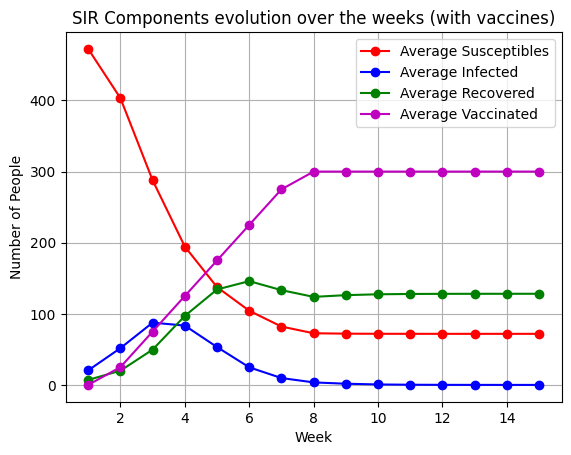

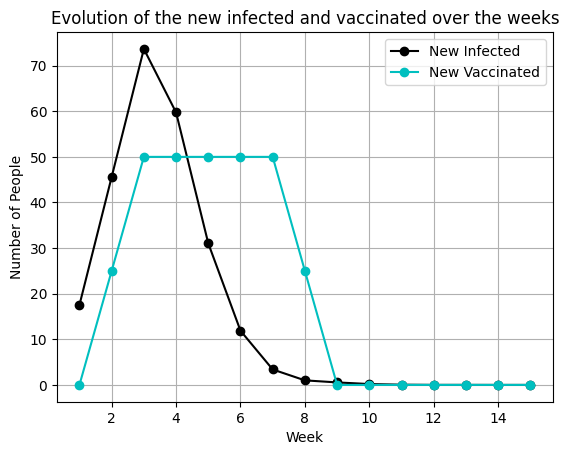

In [ ]:
# Ex 1.3

#Model parameters
n_nodes = 500
k = 6
beta = 0.3
rho = 0.7
N = 100

#Initialization
x0 = np.zeros(n_nodes, dtype = int)
n_infected= 10
infected = np.random.choice(range(0,n_nodes),n_infected,replace=False)
x0[infected] = 1
G = createRadnomGraph(k,n_nodes)
vacc = np.array([0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60], dtype=float)

#Simulation
n_weeks = 15
total_susc = np.zeros(n_weeks)
total_inf = np.zeros(n_weeks)
total_rec = np.zeros(n_weeks)
total_vacc = np.zeros(n_weeks)
new_inf = np.zeros(n_weeks)
for _ in range(N):
    susceptibles, infected, recovered, newly_infected, vaccinated = SIR(G,0.7,0.3,n_weeks,x0,vaccines=vacc)
    total_susc+=susceptibles
    total_inf+=infected
    total_rec+=recovered
    new_inf+=newly_infected
    total_vacc+=vaccinated

total_susc/=N
total_inf/=N
total_rec/=N
new_inf/=N
total_vacc/=N

print(f'Total susceptibles distribution over the {n_weeks} weeks:\n{total_susc}\n')
print(f'Total infected distribution over the {n_weeks} weeks:\n{total_inf}\n')
print(f'Total recovered distribution over the {n_weeks} weeks:\n{total_rec}\n')
print(f'Total vaccinated distribution over the {n_weeks} weeks:\n{total_vacc}\n')
print(f'New infected distribution over the {n_weeks} weeks:\n{new_inf}\n')

plt.plot(range(1,n_weeks+1),total_susc,'ro-',label='Average Susceptibles')
plt.plot(range(1,n_weeks+1),total_inf,'bo-',label='Average Infected')
plt.plot(range(1,n_weeks+1),total_rec,'go-',label='Average Recovered')
plt.plot(range(1,n_weeks+1),total_vacc,'mo-', label="Average Vaccinated")
plt.title('SIR Components evolution over the weeks (with vaccines)')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

new_vacc = np.diff(total_vacc,prepend=0)

plt.plot(range(1,n_weeks+1),new_inf,'ko-')
plt.plot(range(1,n_weeks+1),new_vacc,'co-')
plt.legend(['New Infected','New Vaccinated'])
plt.title('Evolution of the new infected and vaccinated over the weeks')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.grid()
plt.show()

New parameters: (10, 0.19999999999999998, 0.6)
New rmse: 5.2427728032660985

New parameters: (10, 0.19999999999999998, 0.7)
New rmse: 5.149304160110697

Found parameters are:
- k = 10
- beta = 0.19999999999999998
- rho = 0.7 

RMSE for current parameters = 5.149304160110697
Total susceptibles distribution over the 15 weeks:
[848.7 779.4 697.8 605.8 505.2 414.3 334.6 284.3 270.5 266.3 263.7 261.9
 260.7 259.7 259.2]

Total infected distribution over the 15 weeks:
[ 1.5  4.9  9.8 21.8 36.5 43.6 36.4 23.8 13.9  8.1  4.8  3.3  2.3  1.8
  1.2]

Total recovered distribution over the 15 weeks:
[  0.8   1.7   4.4  10.4  22.3  41.1  63.   79.9  94.6 104.6 110.5 113.8
 116.  117.5 118.6]

Total vaccinated distribution over the 15 weeks:
[ 83. 148. 222. 296. 370. 435. 500. 546. 555. 555. 555. 555. 555. 555.
 555.]

New infected distribution over the 15 weeks:
[ 1.3  4.7  8.2 19.3 30.9 33.3 24.3 14.3  6.9  4.2  2.6  1.8  1.2  1.
  0.5]



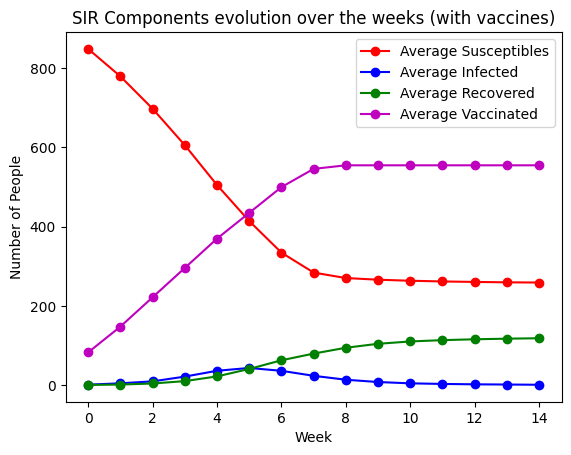

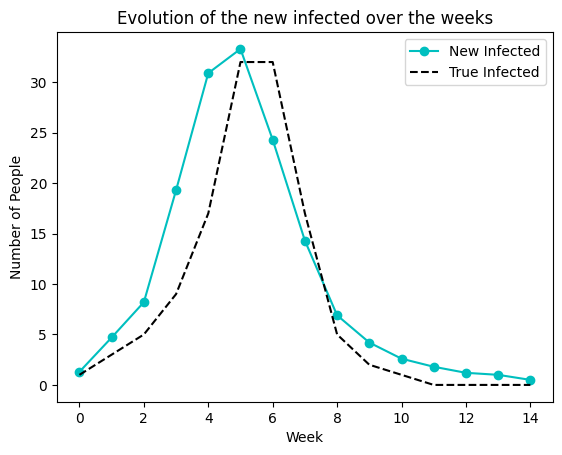

In [ ]:
# Ex 1.4

from math import inf
import matplotlib.pyplot as plt
import numpy as np

#Model parameters
n_nodes = 934
n_weeks = 15
N = 10
vaccines = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60],dtype=float)
true_infected = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0],dtype=float)

parameters = [10,0.3,0.6]
nsteps = 0
rmse = inf
total_susc = np.zeros(n_weeks)
total_inf = np.zeros(n_weeks)
total_rec = np.zeros(n_weeks)
total_vacc = np.zeros(n_weeks)
new_inf = np.zeros(n_weeks)
#Find parameters
while nsteps<10:
  parameters_dict = parameterSearch(n_nodes,n_weeks,N,vaccines,true_infected[1:],parameters)
  new_parameters = min(parameters_dict, key=lambda k: parameters_dict[k][0])
  new_rmse = parameters_dict[new_parameters][0]
  new_total_susc = parameters_dict[new_parameters][1]
  new_total_inf = parameters_dict[new_parameters][2]
  new_total_rec = parameters_dict[new_parameters][3]
  new_new_inf = parameters_dict[new_parameters][4]
  new_total_vacc = parameters_dict[new_parameters][5]
  if new_rmse>rmse:
    break
  print(f'New parameters: {new_parameters}')
  print(f'New rmse: {new_rmse}\n')
  parameters = new_parameters
  rmse = new_rmse
  total_susc = new_total_susc
  total_inf = new_total_inf
  total_rec = new_total_rec
  new_inf = new_new_inf
  total_vacc = new_total_vacc
  nsteps+=1
k = parameters[0]
beta = parameters[1]
rho = parameters[2]
print("Found parameters are:")
print("- k =",k)
print("- beta =",beta)
print("- rho =",rho,'\n')

print('RMSE for current parameters =',rmse)

print(f'Total susceptibles distribution over the {n_weeks} weeks:\n{total_susc}\n')
print(f'Total infected distribution over the {n_weeks} weeks:\n{total_inf}\n')
print(f'Total recovered distribution over the {n_weeks} weeks:\n{total_rec}\n')
print(f'Total vaccinated distribution over the {n_weeks} weeks:\n{total_vacc}\n')
print(f'New infected distribution over the {n_weeks} weeks:\n{new_inf}\n')

plt.plot(total_susc,'ro-',label='Average Susceptibles')
plt.plot(total_inf,'bo-',label='Average Infected')
plt.plot(total_rec,'go-',label='Average Recovered')
plt.plot(total_vacc,'mo-', label="Average Vaccinated")
plt.title('SIR Components evolution over the weeks (with vaccines)')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.show()

plt.plot(new_inf,'co-')
plt.plot(true_infected[1:],'k--')
plt.legend(['New Infected','True Infected'])
plt.title('Evolution of the new infected over the weeks')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.show()

Text(0.5, 1.0, 'Potential evolution')

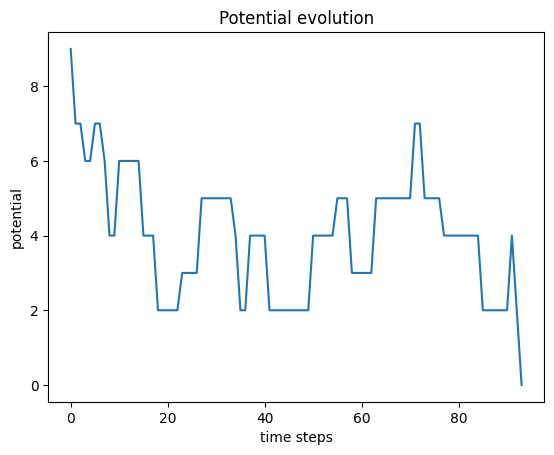

In [11]:
# 2.a

import numpy as np
import networkx as nx
from numpy.random import choice
import matplotlib.pyplot as plt

G= nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9)])
W=nx.convert_matrix.to_numpy_array(G)

def cost(x1,x2):
  if x1 == x2:
    return 1
  else:
    return 0

def potential(W,x):
  sum=0
  for i in range(len(x)):
    for j in range(len(x)):
      sum += W[i,j] * cost(x[i],x[j])
  return 0.5 * sum

def color_prob(W,x,i,a,s,t):
  sum_a=0
  sum_s=0
  for j in range(len(x)):
    sum_a += W[i,j] * cost(a,x[j])
    sum_s += W[i,j] * cost(s,x[j])
  eta = t/100
  p_a= (np.exp(-eta*sum_a) / (np.exp(-eta*sum_a)+np.exp(-eta*sum_s)))
  p_s= 1-p_a
  return [p_a, p_s]


x0= np.zeros(10, dtype=int)   # red=0 green=1

states=[]
states.append(x0)

t = 0

u= potential(W,states[t])
U=[u]

while u > 0:
  x= states[t]
  I= choice(G.nodes,1)[0]
  color= choice([0,1],1,p=color_prob(W,states[t],I,0,1,t))
  x[I]=color
  states.append(x)
  t += 1
  u= potential(W,states[t])
  U.append(u)

plt.figure()
plt.plot(U)
plt.xlabel("time steps")
plt.ylabel("potential")
plt.title("Potential evolution")





Text(0.5, 1.0, 'Potential evolution')

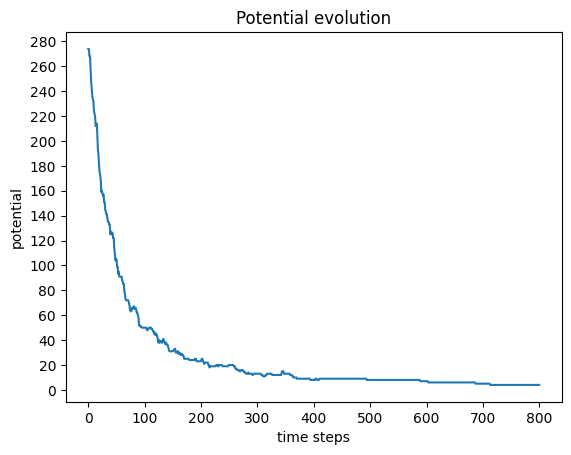

In [26]:
# 2.b

# CHECK wifi.mat and coords.mat are loaded

import scipy as sp
import numpy as np
import networkx as nx
from numpy.random import choice
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def cost(x1,x2):
  if x1 == x2:
    return 2
  elif np.abs(x1-x2)==1:
    return 1
  else:
    return 0

def potential(W,x):
  sum=0
  for i in range(len(x)):
    for j in range(len(x)):
      sum += W[i,j] * cost(x[i],x[j])
  return 0.5 * sum

def color_prob(W,x,i,t):
  sums={1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0}    # {1 : red,2 : green,3 : blue,4 : yellow,5 : magenta,6 : cyan,7 : white,8 : black}

  for c in sums:
    for j in range(len(x)):
      sums[c] += W[i,j] * cost(c,x[j])
  ''' if t > 1:
    eta= np.log(t)
  else:
    eta= t '''
  eta= t/100

  #print("eta: ", eta)
  sum_vec= np.array(list(sums.values()))
  sum_vec= np.sum(np.exp(-eta*sum_vec))

  probs=[]
  for c in sums:
    probs.append((np.exp(-eta*sums[c]) / sum_vec))

  return probs

W = sp.io.loadmat("wifi.mat")['wifi']
coords = sp.io.loadmat("coords.mat")['coords']
G= nx.from_numpy_array(W)

x0= np.ones(len(W[0,:]), dtype=int)
''' for i in range(len(W[0,:])):
  x0[i]=choice([1,2,3,4,5,6,7,8],1) '''

states=[]
states.append(x0)

t = 0

u= potential(W,states[t])
U=[u]

while t < 800:
  #print(u)
  x= states[t]
  I= choice(len(W[0,:]),1)[0]
  color= choice([1,2,3,4,5,6,7,8],1,p=color_prob(W,x,I,t))
  x[I]=color
  states.append(x)
  t += 1
  u= potential(W,states[t])
  U.append(u)

plt.figure()
plt.plot(U)
plt.xlabel("time steps")
plt.ylabel("potential")
yticks=[20*i for i in range(15)]
plt.yticks(yticks)
plt.title("Potential evolution")





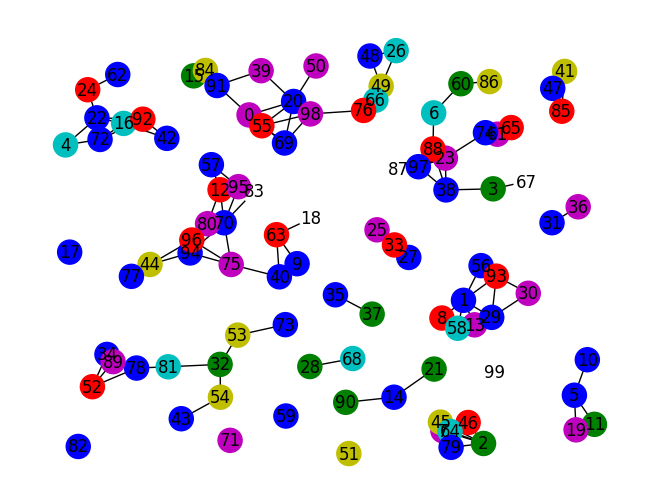

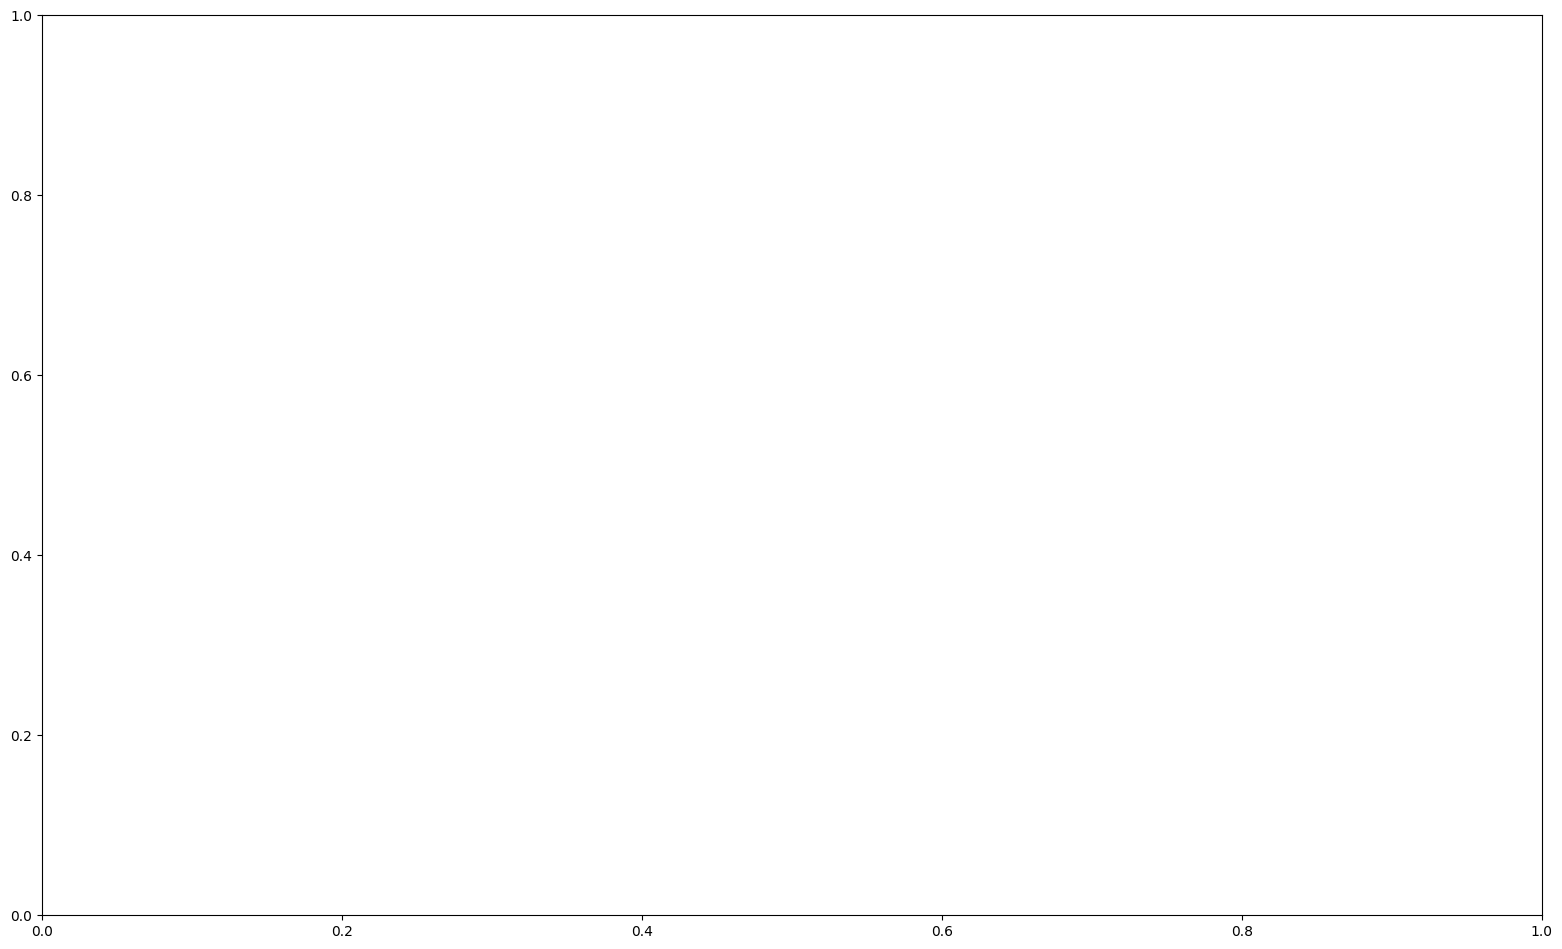

In [5]:
num_to_colors = {1:'r', 2:'g', 3:'b', 4:'y', 5:'m', 6:'c', 7:'w', 8:'b'}
colors = [num_to_colors[num] for num in states[-1]]
nx.draw(G, pos=coords, node_color=colors, with_labels=True)

#Animation (does not run on Colab)
fig, ax = plt.subplots()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
fig.set_size_inches(15, 9)
pos = coords
def animate(frame):
    ax.clear()
    colors = [num_to_colors[num] for num in states[frame]]
    nx.draw(G, pos=pos, node_color=colors, with_labels=True)
animation = FuncAnimation(fig, animate, frames=len(states), interval=1000/len(states), repeat=False)
plt.show()

In [8]:
print(U[-1])

5.0


In [ ]:
# colorability property of the given graph

colors_dict= nx.greedy_color(G)
ncolors=len(set(colors_dict.values()))
print(ncolors)

6


In [10]:
# variant of the previous algorithm to confirm the obtained results
# needs cost, potential and color_prob functions from the code cell above

import scipy as sp
import numpy as np
import networkx as nx
from numpy.random import choice

# returns the potential of the subgraph composed by given nodes
def subgraph_potential(W,x,nodes):
  sum=0
  for i in nodes:
    for j in nodes:
      sum += W[i,j] * cost(x[i],x[j])
  return 0.5 * sum

# returns the list of connected components in G as sets and a dictionary with (index in conn_comp, potential) key-value pairs
def overview_potentials(G,W,x):
  conn_comp=[s for s in nx.connected_components(G)]
  dict_cc={i:0 for i in range(len(conn_comp))}
  for i in dict_cc:
    dict_cc[i]=subgraph_potential(W,x,conn_comp[i])
  return conn_comp, dict_cc

# extracts the connected component with the highest potential
def max_potential_comp(d):
  ord_dict= sorted(d.items(),key= lambda x: x[1], reverse=True)
  return ord_dict[0]


W = sp.io.loadmat("wifi.mat")['wifi']
coords = sp.io.loadmat("coords.mat")['coords']
G= nx.from_numpy_array(W)

x0= np.ones(len(W[0,:]), dtype=int)

states=[]
states.append(x0)

t = 0

u= potential(W,states[t])

conn_comp, dict_cc= overview_potentials(G,W,x0)

prev_node= -1
prev_set=set()
same_set=0

non_decreasing_pot={}

while dict_cc:
  to_minimize= max_potential_comp(dict_cc)
  index, pot= to_minimize[0], to_minimize[1]
  subgraph= conn_comp[index]
  if pot == 0:          # if the given subgraph has zero potential no further improvements can be made, delete from the dictionary
    del dict_cc[index]
    #print("deleted 0", subgraph)
    continue
  if subgraph == prev_set:
    same_set += 1
    if same_set == 500:   # if the given subgraph has been picked up too many times consecutively no further improvements can be made, delete from the dictionary
      same_set=0
      del dict_cc[index]
      #print("deleted rep", subgraph, pot)
      non_decreasing_pot[index]=pot     # remember those components left with a non-null potential
      continue
  else:
    same_set=0
  prev_set= subgraph
  x= states[t]
  I= choice(list(subgraph))
  while I == prev_node:       # avoid selecting the same node consecutively
    I= choice(list(subgraph))
  prev_node= I
  color= choice([1,2,3,4,5,6,7,8],1,p=color_prob(W,x,I,t))[0]
  #print(u, subgraph, pot, I, x[I], color)
  x[I]=color
  states.append(x)
  t += 1
  new_pot= subgraph_potential(W,x,subgraph)
  dict_cc[index]= new_pot
  u= potential(W,states[t])

print("POTENTIAL: ", u)
print("remaining subgraphs with a non-null potential: ")
residual_components=[(conn_comp[i], non_decreasing_pot[i]) for i in non_decreasing_pot]
print(residual_components)

POTENTIAL:  4.0
remaining subgraphs with a non-null potential: 
[({64, 2, 7, 45, 46, 79}, 3.0), ({1, 8, 13, 93, 56, 58, 29, 30}, 1.0)]
